# SPH6004 Assignment 1 by Liang Jingyu

## 1. Import Libraries & Load datasets

In [36]:
# Import Libs & Load datasets
import pandas as pd
import pprint
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV


df = pd.read_csv('./SPHAssignment1.csv')
#df.head()

## 2. Data Preprocessing

### 2.1 Exclude columns with too many Empty Value 

{'Columns with Less than 40% empty values:': 34,
 'Columns with Less than 50% empty values:': 45,
 'Columns with Less than 55% empty values:': 45,
 'Columns with Less than 60% empty values:': 47,
 'Columns with Less than 70% empty values:': 47,
 'Columns with Less than 80% empty values:': 50}


Text(0.5, 0, '% missing')

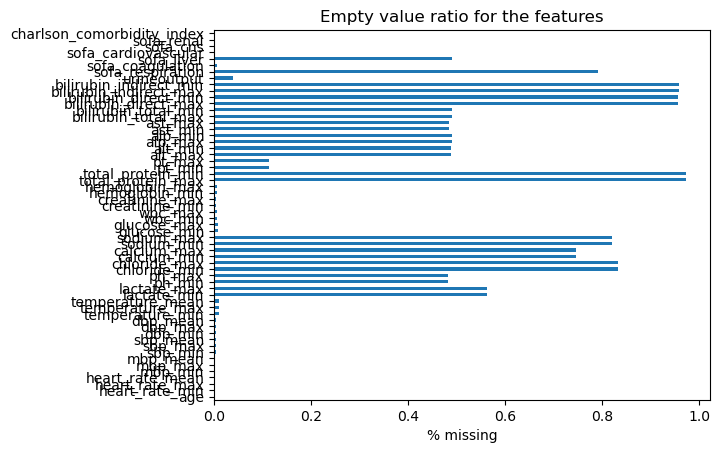

In [44]:
# Empty Value Analysis
empty_pct = df.isnull().sum() / len(df)

# Count the number of columns with less than 70% null values
dict_cols = {'Columns with Less than 80% empty values:' : (empty_pct < 0.8).sum(),
             'Columns with Less than 70% empty values:' : (empty_pct < 0.7).sum(),
             'Columns with Less than 60% empty values:' : (empty_pct < 0.6).sum(),
             'Columns with Less than 55% empty values:' : (empty_pct < 0.55).sum(),
             'Columns with Less than 50% empty values:' : (empty_pct < 0.5).sum(),
             'Columns with Less than 40% empty values:' : (empty_pct < 0.4).sum()}
pprint.pprint(dict_cols, width=1)

ax = empty_pct[1:-1].plot.barh(title='Empty value ratio for the features')
ax.set_xlabel("% missing")

#### By comparing the number of columns that have great ratio of empty values,  set 60% as the threshold to exclude columns

In [38]:
#Data Preprocessing --  Exclude columns with more than 60% empty values
new_df = df.loc[:, empty_pct < 0.6]

### 2.2 Convert non-numeric value & Empty Value Replacement

In [39]:
#Data Preprocessing -- Convert non-numeric value to be numeric value
#new_df['gender'] = new_df['gender'].apply(lambda x:  1 if x == 'M' else 0).astype(int)
new_df['gender'] = new_df['gender'].replace(['M','F'],[0,1])
new_df['outcome'] = new_df['outcome'].astype(int)

# Apply SimpleImputer class to replace null value with mean value 
imputer = SimpleImputer(strategy='median')
imputer.fit(new_df)

# Transform the data by replacing missing values with the mean value of the corresponding column
new_df = pd.DataFrame(imputer.transform(new_df),columns = new_df.columns)

# Save the new dataframe to a CSV file
new_df.to_csv('SPHAssignment1_clean.csv', index=False)

C:\Users\LancerLocal.LAPTOP-LN773K3K\AppData\Local\Temp\ipykernel_14560\3249809993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['gender'] = new_df['gender'].replace(['M','F'],[0,1])
C:\Users\LancerLocal.LAPTOP-LN773K3K\AppData\Local\Temp\ipykernel_14560\3249809993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['outcome'] = new_df['outcome'].astype(int)


### 2.3 Define x, y & Dataset split

In [40]:
# Define x,y 
x = new_df.iloc[:,:-1]
y = new_df.iloc[:,-1]

# Split dataset into training and testing set after feature selection
# X as Features & y as Label
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
# print (X_train.shape)
# print (X_test.shape)
# print (y_train.shape)
# print (y_test.shape)

### 2.4 Standardization (X_train & X_test)

In [41]:
# Standardize and format back to Dataframe for following processing
scaler = StandardScaler()

X_train_std = pd.DataFrame(scaler.fit_transform(X_train),columns = x.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns = x.columns)

### 2.5 Oversampling (X_train & y_train)

In [42]:
# Apply SMOTE and format back to Dataframe for following processing
smote = SMOTE(random_state=21) # 初始化SMOTE对象
X_train_smt, y_train_smt = smote.fit_resample(X_train_std, y_train)
#X_train_smt, y_train_smt = pd.DataFrame(X_train_smt),pd.DataFrame(y_train_smt)
print(type(X_train_smt))
print(type(y_train_smt))
print (X_train_smt.shape)
print (y_train_smt.shape)
# X_train_smt
# y_train_smt

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(52730, 46)
(52730,)


## 3. Feature Selection

### 3.1 Apply Genetic Selection

In [43]:
#clf = RandomForestClassifier(n_estimators=50,random_state=21)
clf = LogisticRegression(solver='saga')
#clf = DecisionTreeClassifier(random_state=21)

# Use the genetic algorithm for feature selection
selector = GeneticSelectionCV(clf,
                              cv=5,
                              verbose=1,
                              scoring="f1",
                              max_features=30,
                              n_population=50,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=50,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              tournament_size=3,
                              caching=True,
                              n_jobs=-1)


# Select the best features using the genetic algorithm
selector.fit(X_train_smt, y_train_smt)

# Select the features in the original dataset
selected_features = x.columns[selector.support_]
print(len(selected_features))
print("Selected features Results: ",selected_features)

Selecting features with genetic algorithm.
gen	nevals	avg                               	std                            	min                            	max                               
0  	50    	[  0.932295  15.66       0.020911]	[ 0.013062  7.237707  0.004432]	[ 0.895088  1.        0.015514]	[  0.964344  29.         0.041191]
1  	28    	[  0.940635  18.38       0.020577]	[ 0.009118  6.305204  0.004135]	[ 0.910565  1.        0.015335]	[  0.964344  28.         0.041191]
2  	36    	[  0.943616  19.38       0.020814]	[ 0.010424  5.799621  0.004912]	[ 0.885603  1.        0.015473]	[  0.964344  28.         0.041191]
3  	29    	[  0.946222  20.82       0.021668]	[ 0.008669  6.380251  0.005655]	[ 0.901953  1.        0.016091]	[  0.964344  30.         0.041191]
4  	25    	[  0.94746   18.86       0.023663]	[ 0.008931  8.813649  0.007424]	[ 0.916056  1.        0.017155]	[  0.964344  30.         0.041191]
5  	29    	[-199.070557   15.86      200.025158]	[ 1400.132778     9.724217  1399.99640

46 	21    	[ 0.957257  1.56      0.039007]      	[ 0.015666  1.116423  0.004904]         	[ 0.910347  1.        0.02475 ]            	[ 0.964344  5.        0.041191]            
47 	24    	[ 0.954312  1.5       0.038533]      	[ 0.02501   1.063015  0.006114]         	[ 0.832078  1.        0.013783]            	[ 0.964344  5.        0.041191]            
48 	36    	[ 0.958833  1.48      0.039178]      	[ 0.012951  1.153083  0.00468 ]         	[ 0.914597  1.        0.024045]            	[ 0.964344  6.        0.041191]            
49 	28    	[-399.081238    1.56      400.037089]	[ 1959.779336     1.373463  1959.584224]	[-10000.            0.            0.018816]	[     0.964344      6.        10000.      ]
50 	29    	[ 0.956788  1.64      0.038275]      	[ 0.013717  1.162067  0.005174]         	[ 0.920413  1.        0.02523 ]            	[ 0.964344  5.        0.041191]            
51 	30    	[-199.059487    1.38      200.038765]	[ 1400.134359     1.093435  1399.994462]	[-10000.            

### Selected features: 
#### Logistic regression classifier without L1 regulartion:(Imputer using mean)
['heart_rate_min', 'mbp_max', 'sbp_min', 'sbp_mean', 'dbp_mean', 'lactate_min', 'lactate_max', 'ph_min', 'hemoglobin_min', 'pt_max', 'alt_min', 'alp_max', 'ast_min', 'bilirubin_total_max', 'sofa_coagulation', 'sofa_cns', 'charlson_comorbidity_index']
#### Logistic regression classifier L1 regulartion + solver:(Imputer using mean)
['mbp_max', 'mbp_mean', 'dbp_min', 'dbp_max', 'alt_max', 'alt_min','alp_min', 'ast_max']
#### Logistic regression classifier Standardization + L1 regulartion + solver: (Imputer using mean)     
['mbp_min', 'mbp_mean', 'alt_min', 'ast_max']
#### Logistic regression classifier L2 regulartion + solver:(Imputer using mean)
Trail 1:
['gender', 'age', 'heart_rate_mean', 'temperature_max', 'lactate_min', 'pt_max', 'sofa_liver', 'sofa_cns', 'sofa_renal']
Trail 2:
['dbp_max', 'temperature_max', 'alt_max', 'alp_max', 'alp_min','ast_min', 'ast_max']
Trail 3:
['age', 'heart_rate_max', 'temperature_max', 'glucose_max', 'alt_max','alt_min', 'ast_min', 'ast_max']
#### Logistic regression classifier Standardization + L2 regulartion + solver:    (Imputer using median)
Trail 1:
['age', 'heart_rate_min', 'heart_rate_mean', 'mbp_min', 'sbp_min','dbp_mean', 'temperature_mean', 'lactate_min', 'ph_min', 'glucose_max','hemoglobin_min', 'pt_min', 'pt_max', 'alt_max', 'alp_max', 'ast_min','sofa_liver', 'sofa_cns', 'sofa_renal', 'charlson_comorbidity_index']
Trail 2:
['gender', 'heart_rate_min', 'mbp_min', 'mbp_max', 'dbp_min', 'dbp_mean','temperature_mean', 'lactate_min', 'lactate_max', 'ph_max','glucose_min', 'glucose_max', 'wbc_min', 'creatinine_min', 'alp_min','urineoutput', 'sofa_coagulation', 'sofa_cardiovascular', 'sofa_cns','sofa_renal']
Trail 3:
['heart_rate_min', 'mbp_max', 'sbp_min', 'sbp_max', 'temperature_min','temperature_mean', 'lactate_max', 'ph_min', 'ph_max', 'glucose_min','glucose_max', 'wbc_min', 'hemoglobin_min', 'hemoglobin_max', 'pt_min','pt_max', 'alt_max', 'alt_min', 'alp_max', 'alp_min', 'ast_min', 'ast_max', 'urineoutput', 'sofa_liver', 'sofa_cardiovascular','sofa_cns']

### 3.2 Update X_train and X_test with selected features

In [15]:
# print(type(X_train_smt))
# print(type(X_train_std))
# print(type(X_test_std))

X_train_selected = X_train_smt[selected_features]
X_test_selected = X_test_std[selected_features]

#X_train_selected.shape
# X_test_selected.shape
# print(X_train_selected.shape)
# print(X_test_selected.shape)

# type(X_train_selected)
# type(X_test_selected)

# print(X_train_selected.columns)
# print(X_test_selected.columns)

# print(X_train_selected.shape)
# print(X_test_selected.shape)
# print(y_train_smt.shape)

## 4. Apply  Models

### 4a. Apply  Model 1 - Random Forest

In [16]:
model = RandomForestClassifier(n_estimators=50, random_state=21)
model_name = 'Random Forest'

### 4b. Apply  Model 2 - AdaBoost

In [21]:
model = AdaBoostClassifier(n_estimators=50, random_state=21)
model_name = 'AdaBoost'

### 4c. Apply  Model 3 - Logistic Regression

In [25]:
model = LogisticRegression(random_state=21)
model_name = 'Logistic Regression'

### 4d. Apply  Model 4 - Decision Tree

In [29]:
model = DecisionTreeClassifier()
model_name = 'Decision Tree'

### 4e. Apply  Model 5 - SVM (Excludes since would stuck for each trail)

In [ ]:
# from sklearn.svm import SVC

# model = SVC(kernel='linear', C=1, probability = True, random_state=21)
# model_name = 'SVM'
# type(model)

### 4.1 Model fitting & Predicting

In [30]:
# train the classifier on the training set
model.fit(X_train_selected, y_train_smt)

# make predictions on the testing set
y_pred = model.predict(X_test_selected)

## 5.Model Evaluation

### Evaluate by: Accuracy & Confusion Matrix & Precision & Recall & F1 Score

Model: Decision Tree
Accuracy: 0.897292557272827
Confusion Matrix:
 [[8156  639]
 [ 298   30]]
Precision:  0.04484304932735426
Recall:  0.09146341463414634
F1 Score:  0.06018054162487462


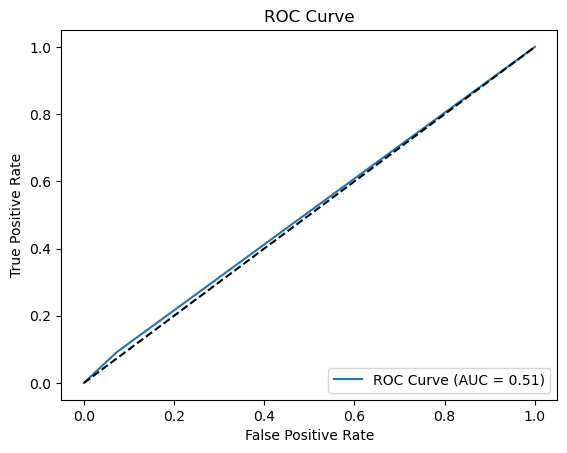

In [31]:
# evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Model: ' + model_name)
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n {conf_matrix}")
print('Precision: ',precision)
print('Recall: ',recall)
print('F1 Score: ',f1)

#ROC曲线和AUC（ROC Curve and AUC）：ROC曲线可以帮助我们评估分类器在不相同的阈值下的表现。
# compute the predicted probabilities and the AUC
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)

# # plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()